In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score, confusion_matrix

pd.set_option('display.max_columns', 500)

In [4]:
df = pd.read_csv("air_pollution.csv")
df["date"] = pd.to_datetime(df["date"])
df["year-month"] = df["date"].dt.strftime("%Y-%m")
df.set_index("date", inplace=True)
df

,pollution_today,dew,temp,press,wnd_spd,snow,rain,pollution_yesterday,year-month
date,,,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0,10.041667,2010-01
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0,145.958333,2010-01
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0,78.833333,2010-01
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0,31.333333,2010-01
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0,42.458333,2010-01
...,...,...,...,...,...,...,...,...,...
2014-12-27,238.666667,-9.666667,-1.791667,1027.833333,9.278333,0.000000,0.0,170.250000,2014-12
2014-12-28,197.375000,-10.791667,1.583333,1019.958333,10.948750,0.000000,0.0,238.666667,2014-12
2014-12-29,159.000000,-12.333333,0.750000,1013.750000,8.000000,0.000000,0.0,197.375000,2014-12


<AxesSubplot:xlabel='date'>

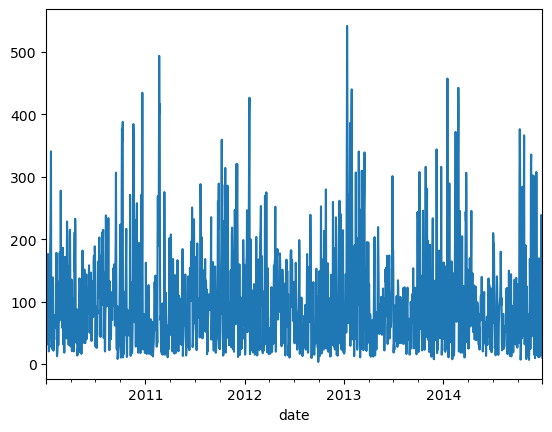

In [5]:
df["pollution_today"].plot()

In [52]:
monthly_pollution = df.pivot_table(index="year-month", values="pollution_today", aggfunc=np.mean)
monthly_pollution.index = pd.to_datetime(monthly_pollution.index)

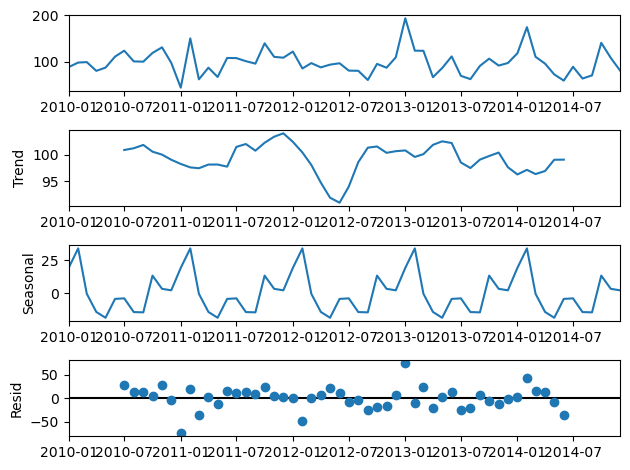

In [82]:
sm.tsa.seasonal_decompose(monthly_pollution, model="add").plot();

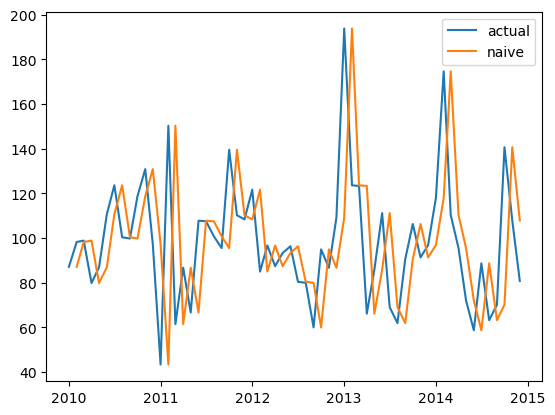

In [29]:
plt.plot(monthly_pollution, label="actual")
plt.plot(monthly_pollution.rolling(1, closed="left").mean(), label="naive")
plt.legend()
plt.show()

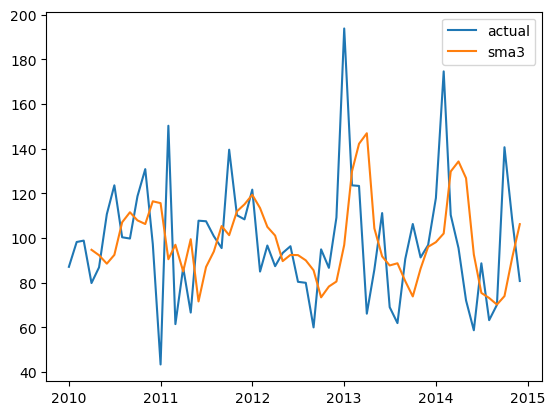

In [34]:
plt.plot(monthly_pollution, label="actual")
plt.plot(monthly_pollution.rolling(3, closed="left").mean(), label="sma3")
plt.legend()
plt.show()

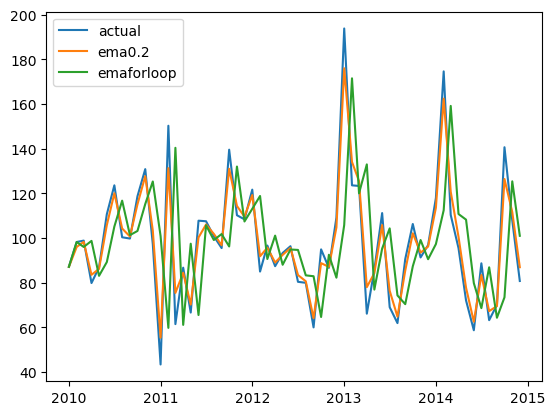

In [46]:
monthly_pollution_ema = monthly_pollution.copy()
for i in range(2, monthly_pollution_ema.shape[0]):
    monthly_pollution_ema.iloc[i, 0] = monthly_pollution.iloc[i-1, 0]*0.8 + monthly_pollution_ema.iloc[i-2, 0]*0.2

plt.plot(monthly_pollution, label="actual")
plt.plot(monthly_pollution.ewm(alpha=0.8, adjust=False).mean(), label="ema0.2")
plt.plot(monthly_pollution_ema, label="emaforloop")

plt.legend()
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


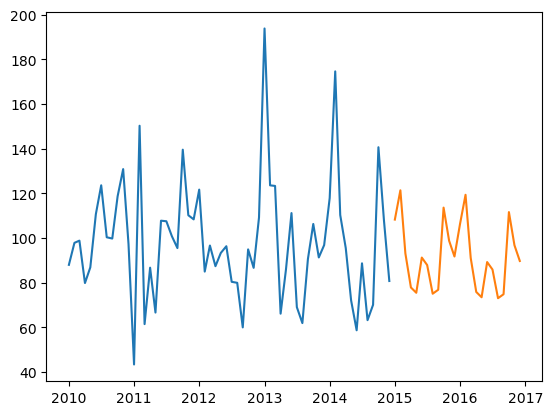

In [81]:
model = sm.tsa.ExponentialSmoothing(monthly_pollution, seasonal_periods=12, trend="add", seasonal="add")
model_fitted = model.fit(smoothing_level=0.2, smoothing_trend=0.04)
monthly_pollution_expsm = pd.DataFrame(model_fitted.forecast(24))
monthly_pollution_expsm.columns = ["pollution_today"]

plt.plot(monthly_pollution)
plt.plot(monthly_pollution_expsm)
plt.show()

In [84]:
sm.tsa.adfuller(monthly_pollution)[1]*100

0.0026332084031286075

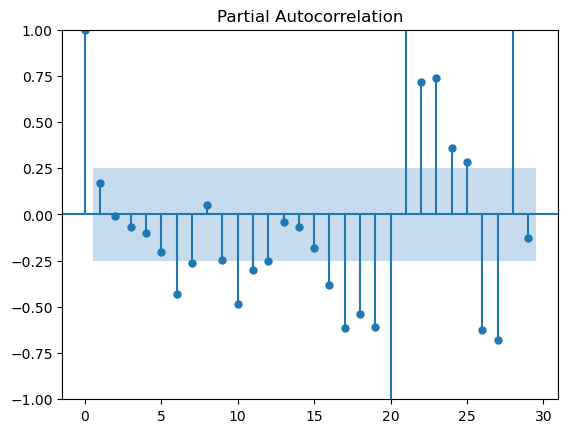

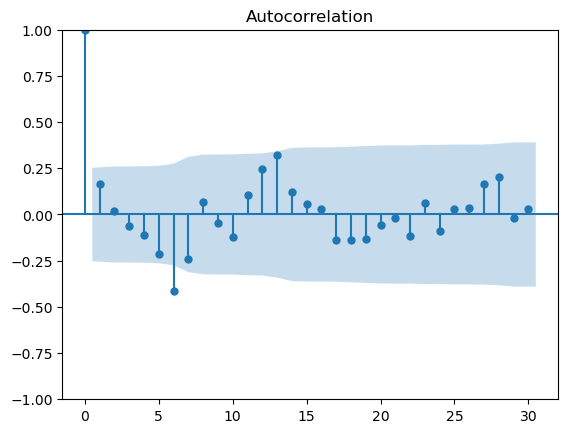

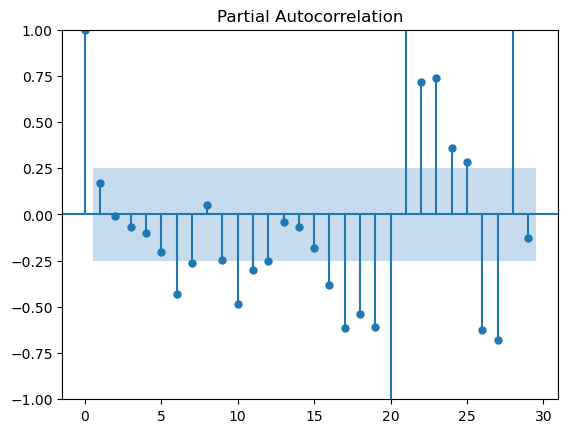

In [89]:
sm.graphics.tsa.plot_acf(monthly_pollution.iloc[:, 0], lags=30)
sm.graphics.tsa.plot_pacf(monthly_pollution.iloc[:, 0], lags=29)

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Ch

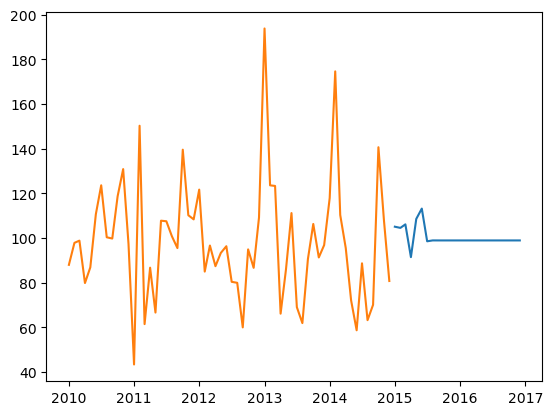

In [106]:
model_fitted = sm.tsa.ARIMA(monthly_pollution["pollution_today"], order=(1, 0, 6)).fit()
plt.plot(model_fitted.forecast(24))
plt.plot(monthly_pollution)
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too 

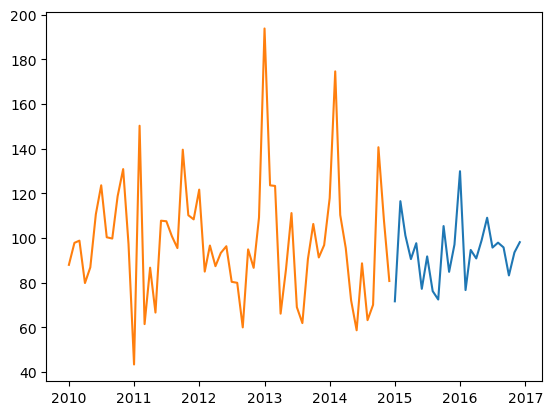

In [107]:
model_fitted = sm.tsa.statespace.SARIMAX(monthly_pollution["pollution_today"], order=(6, 0, 6), seasonal_order=(6, 0, 6, 12)).fit()
plt.plot(model_fitted.forecast(24))
plt.plot(monthly_pollution)
plt.show()